In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm

import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pmdarima import auto_arima

In [45]:
df= pd.read_csv("data/jenny/new_df2.csv")
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
print(df.dtypes)
df.head(3)

date                  datetime64[ns]
month                          int64
year                           int64
Temp                         float64
Flow                         float64
Level                        float64
count                        float64
october_Flow                 float64
november_Flow                float64
december_Temp                float64
january_Temp                 float64
feburary_Temp                float64
october_Level                float64
november_Level               float64
rolling_mean_Temp            float64
rolling_std_Temp             float64
rolling_mean_Flow            float64
rolling_std_Flow             float64
rolling_mean_Level           float64
rolling_std_Level            float64
dtype: object


,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
0,2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316
1,2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316
2,2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316


In [46]:
include_months = [4,5,6,7,8,9]
df = df[df["month"].isin(include_months)]
print(df.shape)

(1859, 20)


In [47]:
use_for_feats = df.iloc[:,7:20].columns.tolist()
use_for_feats

['october_Flow',
 'november_Flow',
 'december_Temp',
 'january_Temp',
 'feburary_Temp',
 'october_Level',
 'november_Level',
 'rolling_mean_Temp',
 'rolling_std_Temp',
 'rolling_mean_Flow',
 'rolling_std_Flow',
 'rolling_mean_Level',
 'rolling_std_Level']

In [48]:
train = df[df["year"] < 2022]
test = df[df["year"] >= 2022]
print(train.shape, test.shape)

(1493, 20) (366, 20)


In [49]:
def impute_for_missing(df):
      missing_cols = df.columns[df.isna().any()].tolist()
      for col in missing_cols:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
      return df

train = impute_for_missing(train)
train.head(3)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
0,2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316
1,2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316
2,2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,4.324905,3.464881,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316


In [50]:
sar = SARIMAX(
      endog=train["count"],
      exog=train[use_for_feats],
      order=(5,0,5),
      seasonal_order=(0,0,2,12),
      trend="n"
)

sar_model = sar.fit(disp=False)

/Users/jennylee/miniforge3/envs/mds574/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jennylee/miniforge3/envs/mds574/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/jennylee/miniforge3/envs/mds574/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
train["pred"] = sar_model.predict(start=0, end=len(train)-1)
adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
train["pred_adjust"] = train.apply(adjust_val, axis=1)
train.head(3)

/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_92052/868661659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["pred"] = sar_model.predict(start=0, end=len(train)-1)
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_92052/868661659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["pred_adjust"] = train.apply(adjust_val, axis=1)


,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred,pred_adjust
0,2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,...,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,67.132542,67.132542
1,2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,...,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,35.398764,35.398764
2,2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,...,0.795806,1.16645,9.514444,2.539781,8.101333,3.857294,0.8584,0.102316,32.136099,32.136099


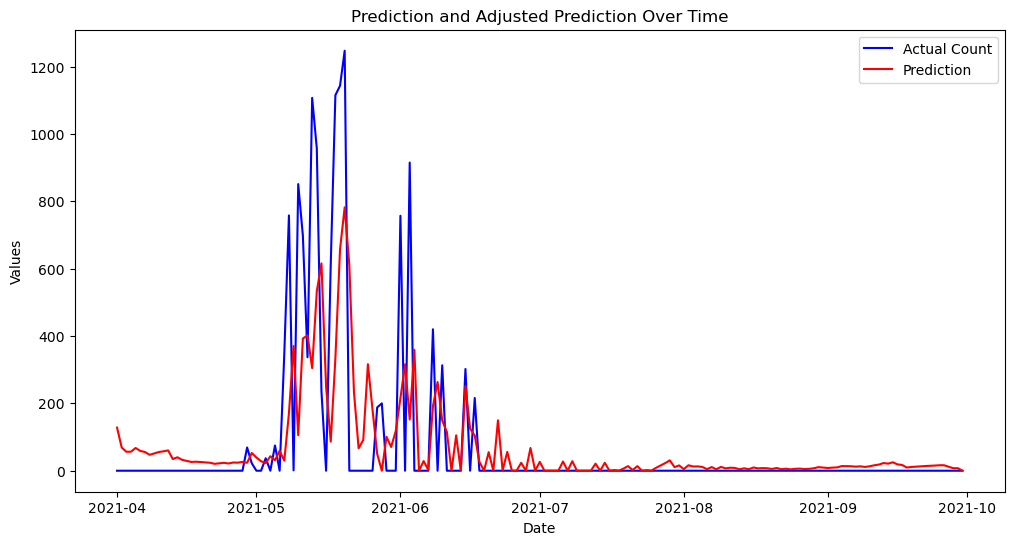

In [59]:
def plot_model(df, subset_year=None):
      df = df.set_index("date")
      if subset_year != None:
            df = df[df["year"] == subset_year]
      adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
      if "pred_adjust" not in df.columns.tolist():
            df["pred_adjust"] = df.apply(adjust_val, axis=1)

      plt.figure(figsize=(12, 6))
      plt.plot(df.index, df['count'], label='Actual Count', color='blue')
      plt.plot(df.index, df['pred_adjust'], label='Prediction', color='red')

      plt.title('Prediction and Adjusted Prediction Over Time')
      plt.xlabel('Date')
      plt.ylabel('Values')

      plt.legend()
      plt.show()

plot_model(train, 2021)

In [53]:
def make_forecast(df=test, forecast_days=len(test), model=sar_model):
      forecast = model.forecast(steps=forecast_days, exog=df[use_for_feats])
      forecast_list = forecast.tolist()
      df["pred"] = forecast_list
      adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
      df["pred_adjust"] = df.apply(adjust_val, axis=1).astype(int)

      return df

test_pred = make_forecast()
test_pred.head(3)

/Users/jennylee/miniforge3/envs/mds574/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jennylee/miniforge3/envs/mds574/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_92052/1759779414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"] = forecast_list
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level,pred,pred_adjust
3132,2022-04-01,4,2022,5.879167,13.550,1.0085,0.0,23.103871,66.455,1.127608,...,1.139161,1.681733,6.570574,2.035608,20.335667,6.285336,1.151983,0.124264,7.237846,7
3133,2022-04-02,4,2022,7.916667,12.605,0.9875,0.0,23.103871,66.455,1.127608,...,1.139161,1.681733,6.630694,2.048224,19.422500,5.231599,1.135783,0.111975,13.001330,13
3134,2022-04-03,4,2022,7.845833,14.540,1.0335,0.0,23.103871,66.455,1.127608,...,1.139161,1.681733,6.691528,2.056571,18.955500,5.009315,1.126550,0.108436,14.466152,14


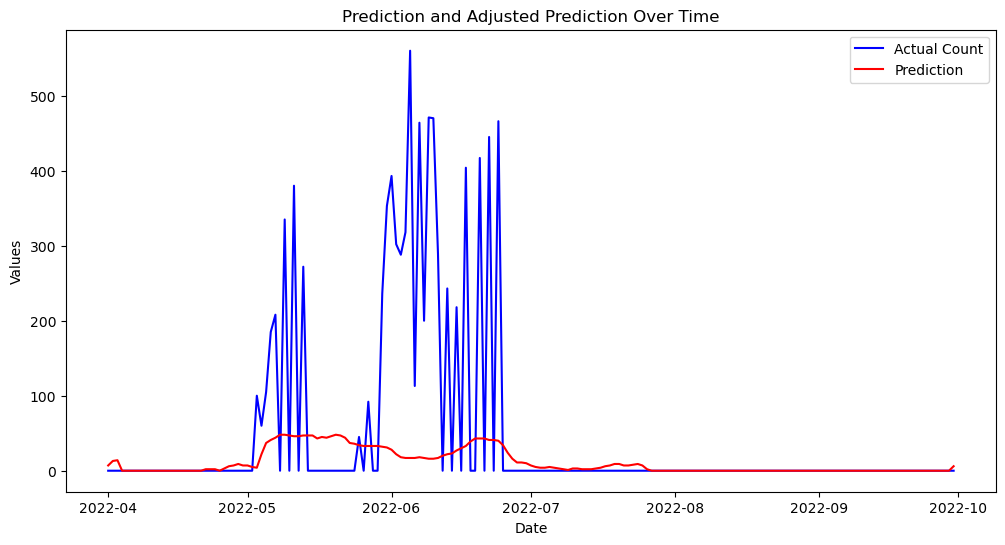

In [58]:
plot_model(test, 2022)

In [105]:
def find_peak_dates(df, column):
      df = df.reset_index()
      year_record = {}

      for year in df["year"].unique().tolist():
            df_year = df[df["year"] == year]
            max_num_ind = df_year[column].idxmax()
            year_record[str(df.loc[max_num_ind, "date"])] = df.loc[max_num_ind, column]
      return year_record

peak_train = find_peak_dates(train, "count")
peak_test = find_peak_dates(test, "pred_adjust")
peak_all = find_peak_dates(df, "count")

In [103]:
peak_all

{'2013-09-02 00:00:00': 0.0,
 '2014-06-16 00:00:00': 881.0,
 '2015-06-16 00:00:00': 713.0,
 '2016-06-01 00:00:00': 1672.0,
 '2017-06-22 00:00:00': 1119.0,
 '2018-06-07 00:00:00': 756.0,
 '2019-05-10 00:00:00': 975.0,
 '2020-06-10 00:00:00': 756.0,
 '2021-05-20 00:00:00': 1247.0,
 '2022-06-05 00:00:00': 560.0,
 '2023-05-30 00:00:00': 976.0}

In [110]:
peak_test


{'2022-05-08 00:00:00': 48, '2023-04-03 00:00:00': 170}

In [107]:
def find_date_simple(df, year=None, count_col="count", detect_num=10):
    df = df.reset_index()
    if year is not None:
        df = df[df["year"] == year]
    if df[count_col].max() <= detect_num:
        print("No date found with the specified condition.")
        return None
    for ind, row in df.iterrows():
        if row[count_col] > detect_num:
            date = row["date"]
            return date

find_date_simple(df, 2017)

Timestamp('2017-06-19 00:00:00')

In [108]:
find_date_simple(train, 2017, "pred_adjust")

Timestamp('2017-04-28 00:00:00')